In [4]:
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import ticker
import polars as pl
import matplotlib.font_manager as fm
import numpy as np
import srsly
from itertools import permutations, combinations, product
from tqdm.auto import tqdm

In [2]:
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [8]:
def load_from_folder(path: Path, metrics: list[str]) -> pl.DataFrame:
    list_df = []
    for p in tqdm(list(path.rglob("*tb_logs.parquet"))):
        strategy = p.parents[0].name.split("_")[0]
        dataset = p.parents[1].name
        
        meta = srsly.read_yaml(p.parent / "hparams.yaml")
        
        df = (
            pl.scan_parquet(p)
            .filter(pl.col("tag").is_in(metrics))
            .with_columns(
                strategy=pl.lit(strategy), 
                dataset=pl.lit(dataset), 
                path=pl.lit(p.parent.name),
                data_seed=meta["data"]["seed"],
                model_seed=meta["model"]["seed"],
                seed=pl.lit(f'{meta["data"]["seed"]}-{meta["model"]["seed"]}')
            )
        )

        list_df.append(df)

    return (
        pl.concat(list_df)
        # .groupby(["strategy", "dataset", "step"])
        # .agg(mean=pl.col("value").mean(), std=pl.col("value").std(), n=pl.count("value"))
        .collect(streaming=True)
    )

In [9]:
path = Path("../outputs/multirun/seeds/")
initial_path = Path("../outputs/multirun/initial_set/")

In [10]:
seeds_df = load_from_folder(path, ["test/f1_class1_vs_budget"])

  0%|          | 0/179 [00:00<?, ?it/s]

In [22]:
initial_df = load_from_folder(initial_path, ["test/f1_class1_vs_budget"])

  0%|          | 0/43 [00:00<?, ?it/s]

In [29]:
mapper = {
    "random": "Random",
    "randomsubset": "RandomSubset",
    "all": "AnchorAL",
    "all-anchorssubset-min": "SEALS",
}

seeds_df = seeds_df.with_columns(strategy_name=pl.col("strategy").map_dict(mapper))
initial_df = initial_df.with_columns(strategy_name=pl.col("strategy").map_dict(mapper))

In [33]:
col_order = ["amazon", "pubmed", "eurlex", "agnews", "wiki_toxic"]

In [35]:
mpl.rcParams["font.family"] = "monospace"  # "DejaVu Sans Mono"
plt.rcParams["font.size"] = 18
# plt.rcParams["axes.linewidth"] = 2
plt.style.use("bmh")
sns.set_context("paper")

# sorted(matplotlib.font_manager.get_font_names())

---
### checks

In [23]:
seeds_df["strategy"].unique().to_list()

['all', 'all-anchorssubset-min', 'random', 'randomsubset']

In [24]:
seeds_df.groupby(["dataset", "strategy"]).agg(pl.col("path").n_unique()).sort(["strategy"]).filter(pl.col("path") < 9)

dataset,strategy,path
str,str,u32
"""wiki_toxic""","""all-anchorssubset-min""",8


In [25]:
seeds_df.filter(
    (pl.col("dataset") == "amazon") & (pl.col("strategy") == "all-anchorssubset-min")
)["seed"].value_counts()

seed,counts
str,u32
"""1994-0""",101
"""42-42""",101
"""0-1994""",101
"""1994-1994""",101
"""1994-42""",101
"""42-0""",101
"""42-1994""",101
"""0-0""",101
"""0-42""",101


In [26]:
seeds_df.filter(
    (pl.col("dataset") == "wiki_toxic") & (pl.col("strategy") == "all-anchorssubset-min")
).groupby(["seed", "path"]).agg(pl.col("value").mean()).sort(pl.col("seed"))

seed,path,value
str,str,f64
"""0-0""","""all-anchorssubset-min_2023-06-17T07-35-24_active_train_4""",0.720472
"""0-42""","""all-anchorssubset-min_2023-06-17T07-35-24_active_train_3""",0.716577
"""1994-0""","""all-anchorssubset-min_2023-06-17T07-35-24_active_train_7""",0.709349
"""1994-1994""","""all-anchorssubset-min_2023-06-17T07-35-24_active_train_8""",0.706702
"""1994-42""","""all-anchorssubset-min_2023-06-17T07-35-24_active_train_6""",0.720855
"""42-0""","""all-anchorssubset-min_2023-06-17T07-35-24_active_train_1""",0.714171
"""42-1994""","""all-anchorssubset-min_2023-06-17T07-35-24_active_train_2""",0.697284
"""42-42""","""all-anchorssubset-min_2023-06-17T07-35-24_active_train_0""",0.70414


In [27]:
done = set(
    seeds_df
    .filter(
        (pl.col("dataset") == "wiki_toxic")
        & (pl.col("strategy") == "all-anchorssubset-min")
    )["seed"].unique()
)
total = set(f"{i}-{j}" for i, j in product([42, 0, 1994], [42, 0, 1994]))
total.difference(done)

{'0-1994'}

---
### Learning curves

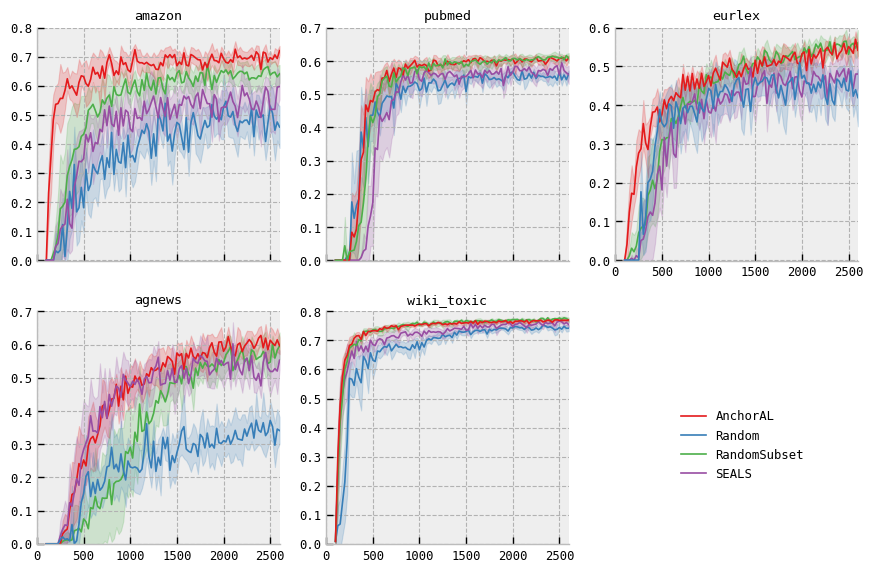

In [37]:
plot_data = seeds_df.filter(pl.col("strategy_name").is_in(mapper.values())).to_pandas()
strategies = sorted(plot_data["strategy_name"].unique())
palette = dict(zip(strategies, sns.color_palette("Set1", n_colors=len(strategies))))
ymax = 2600 

g = sns.FacetGrid(
    plot_data, 
    col="dataset",  
    col_wrap=3,
    sharex=True,
    legend_out=True,
    # palette=palette,
    despine=True,
    xlim=(0, ymax), 
    ylim=(-.001,None),
    sharey=False,
    col_order=col_order,
    # hue_order=strategies,)
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 2),
    # ax=ax,
    hue="strategy_name",
    palette=palette,
    # style="strategy_name",
)

g.axes_dict["agnews"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.6)
g.axes_dict["pubmed"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.65)
g.axes_dict["eurlex"].set_ylim(-.001, 0.6 if ymax == 2600 else 0.55)
g.axes_dict["wiki_toxic"].set_ylim(-.001, 0.8)
g.axes_dict["amazon"].set_ylim(-.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}",)

g.add_legend(label_order=strategies, bbox_to_anchor=(.82, .25))
# g.despine()
plt.savefig(fname=f"learning_curves_{ymax}.png", dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

---

### Effect of the seed set

In [39]:
plot_data = pl.concat(
    [
        seeds_df.filter(pl.col("strategy_name").is_in(initial_df["strategy_name"].unique().to_list())).with_columns(n_positive=5),
        initial_df.with_columns(strategy_name=pl.col("strategy").map_dict(mapper), n_positive=1),
    ]
).to_pandas()


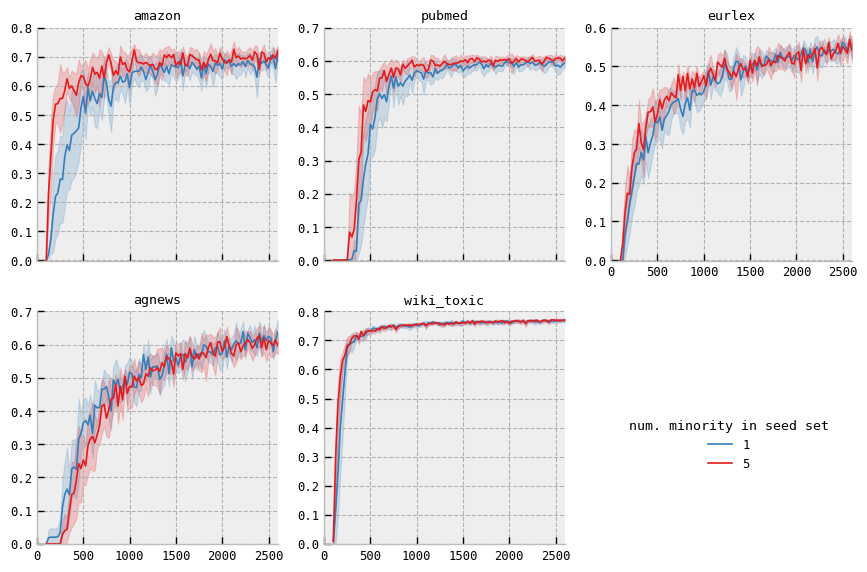

In [165]:
ymax = 2600 

g = sns.FacetGrid(
    plot_data, 
    col="dataset",  
    col_wrap=3,
    sharex=True,
    legend_out=True,
    # palette=palette,
    despine=True,
    xlim=(0, ymax), 
    ylim=(-.001,None),
    sharey=False,
    col_order=col_order,
    # hue_order=strategies,)
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 2),
    # ax=ax,
    hue="n_positive",
    palette=dict(zip([5, 1], sns.color_palette("Set1", n_colors=2))),
    # style="strategy_name",
)

g.axes_dict["agnews"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.6)
g.axes_dict["pubmed"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.65)
g.axes_dict["eurlex"].set_ylim(-.001, 0.6 if ymax == 2600 else 0.55)
g.axes_dict["wiki_toxic"].set_ylim(-.001, 0.8)
g.axes_dict["amazon"].set_ylim(-.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}",)

g.add_legend(bbox_to_anchor=(.79, .25), title="num. minority in seed set")
plt.savefig(fname=f"num_minority_seed_set.png", dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

---
### AUC

In [157]:
def f(s) -> str:
    return r"\floatpm[2]{" + s.mean().astype(str) + r"}{" + s.std().astype(str) + r"}"

table_data = pl.concat(
    [
        seeds_df.filter(pl.col("strategy_name").is_in(initial_df["strategy_name"].unique().to_list())).with_columns(n_positive=5),
        initial_df.with_columns(strategy_name=pl.col("strategy").map_dict(mapper), n_positive=1),
    ]
)

print(
   table_data
   .to_pandas()
    .assign(
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000").groupby(["path"])["value"].transform(np.trapz),
    )
    .groupby(["dataset", "strategy_name", "n_positive"])[["auc", "auc_1000"]].agg(f)
    .to_latex()
)

\begin{tabular}{lllll}
\toprule
 &  &  & auc & auc_1000 \\
dataset & strategy_name & n_positive &  &  \\
\midrule
\multirow[t]{2}{*}{agnews} & \multirow[t]{2}{*}{AnchorAL} & 1 & \floatpm[2]{47.497101561787225}{2.138829717676012} & \floatpm[2]{10.962194041969875}{1.2673117360863828} \\
 &  & 5 & \floatpm[2]{45.29856865798744}{2.032709525019498} & \floatpm[2]{9.072946515632793}{1.7982730013435078} \\
\cline{1-5} \cline{2-5}
\multirow[t]{2}{*}{amazon} & \multirow[t]{2}{*}{AnchorAL} & 1 & \floatpm[2]{59.17720160305342}{5.1439294420295925} & \floatpm[2]{16.649370166194178}{3.879656536395077} \\
 &  & 5 & \floatpm[2]{65.52332127517568}{3.184207174369612} & \floatpm[2]{21.41128926236868}{2.1329414620963028} \\
\cline{1-5} \cline{2-5}
\multirow[t]{2}{*}{eurlex} & \multirow[t]{2}{*}{AnchorAL} & 1 & \floatpm[2]{44.31861515183534}{1.6414062111315566} & \floatpm[2]{11.489913583334003}{1.2357580382200384} \\
 &  & 5 & \floatpm[2]{45.9940861703621}{1.3448395380848301} & \floatpm[2]{13.10998473813136

In [164]:
def g(s) -> str:
    return r"\floatpm[2]{" + s["mean"].astype(str) + r"}{" + np.abs(s["std"]).astype(str) + r"}"

(
    table_data
   .to_pandas()
    .assign(
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000").groupby(["path"])["value"].transform(np.trapz),
        dataset=lambda _df: "\\" + _df["dataset"],
        strategy=lambda _df: "\\" + _df["strategy_name"].str.lower(),
    )
    .groupby(["dataset", "strategy", "n_positive"])[["auc", "auc_1000"]].agg(["mean", "std"])
    .stack(0).stack(0).unstack(2)
    .assign(diff=lambda _df: _df[5] - _df[1])
    .unstack(3).stack(0)
    .apply(g, 1)
    .unstack(3)
    # .to_latex()
)

n_positive                                                                      1   
dataset     strategy                                                                
\agnews     \anchoral auc       \floatpm[2]{47.497101561787225}{2.138829717676...  \
                      auc_1000  \floatpm[2]{10.962194041969875}{1.267311736086...   
\amazon     \anchoral auc       \floatpm[2]{59.17720160305342}{5.143929442029595}   
                      auc_1000  \floatpm[2]{16.649370166194178}{3.879656536395...   
\eurlex     \anchoral auc       \floatpm[2]{44.31861515183534}{1.6414062111315...   
                      auc_1000  \floatpm[2]{11.489913583334003}{1.235758038220...   
\pubmed     \anchoral auc       \floatpm[2]{49.058175753110035}{2.859014880699...   
                      auc_1000  \floatpm[2]{11.71137531322246}{1.936642597698138}   
\wiki_toxic \anchoral auc       \floatpm[2]{73.0093089309521}{1.0403148864656755}   
                      auc_1000  \floatpm[2]{24.20852096218409}{0.9731921366623...   

n_positive                                                                      5   
dataset     strategy                                                                
\agnews     \anchoral auc       \floatpm[2]{45.29856865798744}{2.032709525019496}  \
                      auc_1000  \floatpm[2]{9.072946515632793}{1.7982730013435...   
\amazon     \anchoral auc       \floatpm[2]{65.52332127517568}{3.1842071743696...   
                      auc_1000  \floatpm[2]{21.41128926236868}{2.132941462096303}   
\eurlex     \anchoral auc       \floatpm[2]{45.9940861703621}{1.3448395380848341}   
                      auc_1000  \floatpm[2]{13.109984738131365}{0.878257123393...   
\pubmed     \anchoral auc       \floatpm[2]{52.17317733911073}{1.9408697359366...   
                      auc_1000  \floatpm[2]{13.892648783796984}{1.580648448011...   
\wiki_toxic \anchoral auc       \floatpm[2]{73.85059621240686}{0.5333010269428...   
                      auc_1000  \floatpm[2]{25.03818585779259}{0.5065309011593...   

n_positive                                                                   diff  
dataset     strategy                                                               
\agnews     \anchoral auc       \floatpm[2]{-2.198532903799787}{0.106120192656...  
                      auc_1000  \floatpm[2]{-1.8892475263370816}{0.53096126525...  
\amazon     \anchoral auc       \floatpm[2]{6.346119672122256}{1.9597222676599...  
                      auc_1000  \floatpm[2]{4.761919096174502}{1.7467150742987...  
\eurlex     \anchoral auc       \floatpm[2]{1.675471018526764}{0.2965666730467...  
                      auc_1000  \floatpm[2]{1.6200711547973619}{0.357500914826...  
\pubmed     \anchoral auc       \floatpm[2]{3.1150015860006945}{0.918145144762...  
                      auc_1000  \floatpm[2]{2.1812734705745243}{0.355994149686...  
\wiki_toxic \anchoral auc       \floatpm[2]{0.8412872814547541}{0.507013859522...  
                      auc_1000  \floatpm[2]{0.8296648956085022}{0.466661235502...

In [ ]:
 table_data
   .to_pandas()
    .assign(
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000").groupby(["path"])["value"].transform(np.trapz),
    )
    .groupby(["dataset", "strategy_name", "n_positive"])[["auc", "auc_1000"]].agg(f)

In [ ]:
dataset = "amazon"

fig, ax = plt.subplots()

# fig.dpi = dpi

sns.lineplot(
    x="step",
    y="value",
    data=plot_data.filter(pl.col("dataset") == dataset),
    errorbar=("se", 2),
    ax=ax,
    hue="strategy_name",
    palette=palette,
)

ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax.set_xlim(90, 1000)
ax.set_ylim(0, 0.8)

ax.set_xlabel("Budget")
ax.set_ylabel("F1 Minority Class")

# fig.suptitle(dataset.title())
ax.set_title(dataset.title().replace("_", ""), fontsize=12)
# ax.set_title(f"Average over 9 runs", fontsize=10)

# ax.legend(fontsize=10, bbox_to_anchor=(1, 1))
ax.legend(fontsize=10)

sns.despine()
plt.show()